# Consts

In [21]:
from datetime import date

SHOW_ALL_ARTICLES = True

END_DATE = date(2022, 6, 19)
START_DATE = date(2022, 5, 20)

KEYWORD = 'business'
QUERY = 'stock'

API_CLIENT_KEY = 'be7c98826dd24b729bfb35c01fd39de0'


# Imports

In [22]:
import sys
import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ildar/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Install

In [23]:
%pip install newsapi-python

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [24]:
%pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [25]:
from newsapi import NewsApiClient
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import yfinance as yf


In [26]:
pd.set_option('display.max_colwidth',1000)

Function to call one endpoint to get news sources by category

In [27]:
# https://newsapi.org/docs/endpoints/sources
# https://github.com/mattlisiv/newsapi-python

def get_sources(category = None):
  newsapi = NewsApiClient(api_key=API_CLIENT_KEY)
  sources = newsapi.get_sources()
  if category is not None:
    rez = [source['id'] for source in sources['sources'] if source['category'] == category and source['language'] == 'en']
  else:
    rez = [source['id'] for source in sources['sources'] if source['language'] == 'en']
  return rez


Function returns articles by sources (category) with sentiment scores

In [28]:
def get_articles_sentiments(keywrd, startd, sources_list = None, show_all_articles = False):
   
  newsapi = NewsApiClient(api_key= API_CLIENT_KEY)
  if type(startd) == str:
    my_date = datetime.strptime(startd,'%d-%b-%Y')
  else:
    my_date = startd
  if sources_list:
    articles = newsapi.get_everything(q=keywrd,
                                      from_param = my_date.isoformat(), 
                                      to = (my_date + timedelta(days = 1)).isoformat(),
                                      language="en",
                                      sources = ",".join(sources_list),
                                      sort_by="relevancy",
                                      page_size = 100)
  else:
     articles = newsapi.get_everything(q=keywrd,
                                      from_param = my_date.isoformat(), 
                                      to = (my_date + timedelta(days = 1)).isoformat(),
                                      language="en",
                                      sort_by="relevancy",
                                      page_size = 100)
  article_content = ''

  date_sentiments = {}
  date_sentiments_list = []
  seen = set()
  
  for article in articles['articles']:
    if str(article['title']) in seen:
      continue
    else:
      seen.add(str(article['title']))
      article_content = str(article['title']) + '. ' + str(article['description'])
      
      sentiment = sia.polarity_scores(article_content)['compound']
      date_sentiments.setdefault(my_date, []).append(sentiment)
      date_sentiments_list.append((sentiment, article['url'],article['title'],article['description']))

  return pd.DataFrame(date_sentiments_list, columns=['Sentiment','URL','Title','Description'])

# Example with business sources

-0.0553925
40
0                                                                                                                                           Sharlea Brookes cofounded Modern Blk Girl to encourage young women of color to invest, with the goal of closing the gender and racial wealth gaps.
1                                                                                                                                                                       Tesla has been Ark's only winning position over the past year, delivering a 25% return, according to data from Koyfin.
2                                                                                                                               The S&P 500 is on the brink of a bear market, an index of global stocks is headed for a record run of weekly losses, and the Fed won't help, strategists said.
3                                                                                                                            

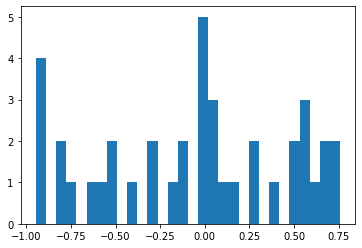

In [29]:
sources = get_sources(KEYWORD)
return_articles = get_articles_sentiments(QUERY, START_DATE, sources_list=sources, show_all_articles=True)
return_articles.Sentiment.hist(bins=30,grid=False)
print(return_articles.Sentiment.mean())
print(return_articles.Sentiment.count())
print(return_articles.Description)

# Sentiment articles for 1 month:  q= 'stocks', 'en' language, with and without business category filter

In [30]:
from datetime import date

current_day = START_DATE
business_sources = get_sources(KEYWORD)
sentiment_all_score = []
sentiment_business_score = []
dates=[]


while current_day <= END_DATE:
  
  dates.append(current_day)

  sentiments_all = get_articles_sentiments(keywrd= QUERY,
                                       startd = current_day,
                                       sources_list = None, 
                                       show_all_articles= True)
  sentiment_all_score.append(sentiments_all.mean())

  sentiments_business = get_articles_sentiments(keywrd= QUERY ,
                                       startd = current_day,
                                       sources_list = business_sources, 
                                       show_all_articles= True)
  
  sentiment_business_score.append(sentiments_business.mean())

  current_day = current_day + timedelta(days=1)

In [31]:
sentiments = pd.DataFrame([dates,np.array(sentiment_all_score),np.array(sentiment_business_score)]).transpose()

In [32]:
sentiments.columns=['Date','All_sources_sentiment','Business_sources_sentiment']

In [33]:
sentiments['Date'] = pd.to_datetime(sentiments['Date'])

In [34]:
sentiments['All_sources_sentiment'] = sentiments['All_sources_sentiment'].astype(float)
sentiments['Business_sources_sentiment'] = sentiments['Business_sources_sentiment'].astype(float)
sentiments.info()
sentiments.set_index("Date", inplace=True)
sentiments.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        31 non-null     datetime64[ns]
 1   All_sources_sentiment       31 non-null     float64       
 2   Business_sources_sentiment  31 non-null     float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 872.0 bytes


,All_sources_sentiment,Business_sources_sentiment
Date,,
2022-05-20,0.055010,-0.055392
2022-05-21,0.214638,-0.093865
2022-05-22,0.173210,0.064898
2022-05-23,0.078857,-0.014124
2022-05-24,0.159426,-0.017581


# 3) Get S&P 500 history market data

In [35]:

import pandas_datareader.data as pdr
from datetime import date

end = END_DATE
start = START_DATE 
print(f'Period 1 year until today: {start} to {end} ')

Period 1 year until today: 2022-05-20 to 2022-06-19 


In [36]:
spx_index = pdr.get_data_stooq('^SPX', start, end) 


<AxesSubplot:title={'center':'1 month price history for index S&P500 Index'}, xlabel='Date'>

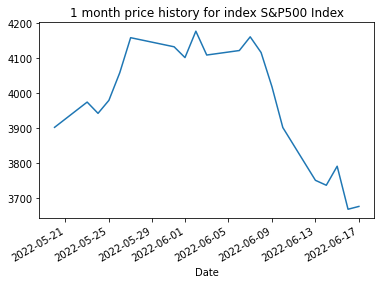

In [37]:
spx_index['Close'].plot(title='1 month price history for index S&P500 Index')

# Join sentiments and S&P500 for joint analysis

In [38]:
sentiments_vs_snp = sentiments.join(spx_index['Close']).dropna()

In [39]:
sentiments_vs_snp.rename(columns={'Close':'s&p500_close'}, inplace=True)

In [40]:
sentiments_vs_snp.head()

,All_sources_sentiment,Business_sources_sentiment,s&p500_close
Date,,,
2022-05-20,0.055010,-0.055392,3901.36
2022-05-23,0.078857,-0.014124,3973.75
2022-05-24,0.159426,-0.017581,3941.48
2022-05-25,0.151413,0.086340,3978.73
2022-05-26,0.134126,0.060856,4057.84


<AxesSubplot:xlabel='Date', ylabel='All_sources_sentiment'>

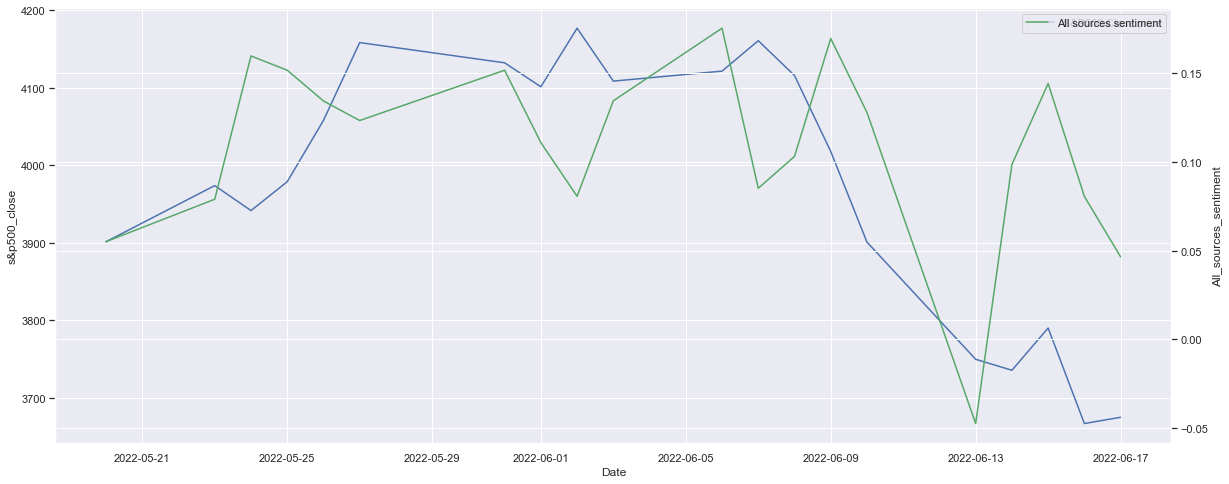

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(20.0,8.0)})


ax=sns.lineplot(data=sentiments_vs_snp['s&p500_close'], color="b",label='S&P500 Close price')
ax2 = plt.twinx()
sns.lineplot(data=sentiments_vs_snp["All_sources_sentiment"], color="g", ax=ax2, label='All sources sentiment')


<AxesSubplot:xlabel='Date', ylabel='Business_sources_sentiment'>

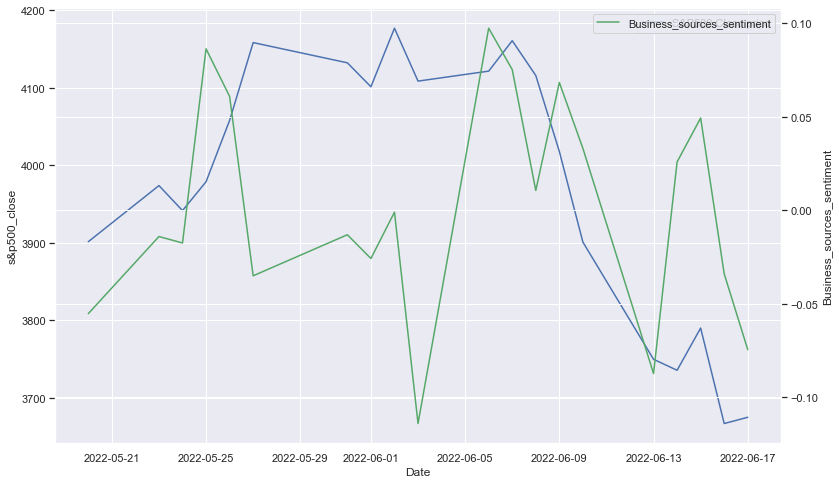

In [42]:
sns.set(rc={'figure.figsize':(13.0,8.0)})


ax=sns.lineplot(data=sentiments_vs_snp['s&p500_close'], color="b", label='S&P500 Close price')
ax2 = plt.twinx()
sns.lineplot(data=sentiments_vs_snp["Business_sources_sentiment"], color="g", ax=ax2, label='Business_sources_sentiment')

# Correlation

In [131]:
import scipy.stats as stats

def get_corr(a, b):
  return stats.pearsonr(a, b)[0]

corr_business = get_corr(sentiments_vs_snp['Business_sources_sentiment'].map(lambda x: (x)).array, sentiments_vs_snp['s&p500_close'].map(lambda x: (x)).array)

corr_all = get_corr(sentiments_vs_snp['All_sources_sentiment'].array, sentiments_vs_snp['s&p500_close'].array)

print("Correlation between Business articles and S&P500: {}".format(corr_business))
print("Correlation between All articles and S&P500: {}".format(corr_all))

Correlation between Business articles and S&P500: 0.2583052516152372
Correlation between All articles and S&P500: 0.44835876275543074
